# Proyek Klasifikasi Gambar: [Vegetable Image Dataset]

- **Nama:** Nabila Alawiyah
- **Email:** nabilaalawiyah.25@gmail.com
- **ID Dicoding:** nabila_alawiyah_B1OF

## Pendahuluan

* Dataset ini merupakan dataset yang berisi gambar dari 15 jenis sayuran.
* Sumber dataset: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

**Saran**
* Mengimplementasikan Callback.

  **Done. Menggunakan callback untuk mengontrol proses tranning**

* Gambar-gambar pada dataset asli memiliki resolusi yang tidak seragam (Tanpa preprocessing).
  
  **Done. Data asli memiliki resolusi yang tidak seragam, dapat dilihat pada Data Loading bagian "Mengetahui resolusi dari setiap gambar"**
* Memiliki 3 buah kelas atau lebih
  
  **Done. Memiliki 8 kelas, yaitu: Baked Potato, Crispy Chicken, Donut, Fries, Hot Dog, Sandwich, Taco, Taquito**
* Dataset yang digunakan berisi minimal 10000 gambar:
  
  **Done. Dataset yang digunakan berisi 12.048 gambar**
* Akurasi pada training set dan testing set minimal 95%.

  **Done. Accuracy 95% dan validasi accuracy 97%**
* Melakukan inference menggunakan salah satu model (TF-Lite, TFJS atau savedmodel)

  **Done. Menggunakan TF-Lite**


## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install pipreqs

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import io

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [ ]:
#!/bin/bash
!curl -L -o vegetable-image-dataset.zip\
  "https://www.kaggle.com/api/v1/datasets/download/misrakahmed/vegetable-image-dataset"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  534M  100  534M    0     0  20.7M      0  0:00:25  0:00:25 --:--:-- 22.9M


In [ ]:
import zipfile

with zipfile.ZipFile('/content/vegetable-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

#### Menyalin 15 folder yang ingin digunakan ke dalam folder dataset

In [ ]:
# Path awal dan tujuan
source_dir = '/content/Vegetable Images'
target_dir = '/content/folder_dataset'

# Membuat folder target jika belum ada
os.makedirs(target_dir, exist_ok=True)

# Daftar folder data: test, train, validation
splits = ['test', 'train', 'validation']

# Menyalin semua isi dari folder test/train/validation ke dalam folder dataset
for split in splits:
    split_path = os.path.join(source_dir, split)
    for class_name in os.listdir(split_path):
        src_class_dir = os.path.join(split_path, class_name)
        dst_class_dir = os.path.join(target_dir, class_name)

        # Pastikan folder tujuan ada
        os.makedirs(dst_class_dir, exist_ok=True)

        # Salin semua file gambar
        for file_name in os.listdir(src_class_dir):
            src_file = os.path.join(src_class_dir, file_name)
            dst_file = os.path.join(dst_class_dir, file_name)
            shutil.copy2(src_file, dst_file)

print("Semua gambar dari test, train, dan validation berhasil digabung ke dalam vegetable/dataset.")

Semua gambar dari test, train, dan validation berhasil digabung ke dalam vegetable/dataset.


#### Menggabungkan 15 folder yang ada di folder_dataset ke dalam folder dataset

In [ ]:
# Path folder asal (semua folder kelas)
source_dir = Path('/content/folder_dataset')            # ganti sesuai lokasi kamu
# Path folder tujuan (semua gambar dikumpulkan jadi satu)
flat_target_dir = Path('/content/dataset')              # ganti sesuai lokasi kamu

# Buat folder target jika belum ada
flat_target_dir.mkdir(parents=True, exist_ok=True)

# Iterasi setiap subfolder di source_dir
for class_dir in source_dir.iterdir():
    if not class_dir.is_dir():
        continue  # lewati file di root source_dir

    # Iterasi setiap file dalam tiap class_dir
    for file_path in class_dir.iterdir():
        if not file_path.is_file():
            continue  # lewati folder/folder dalam subfolder

        # Tambahkan prefix nama kelas ke nama file untuk menghindari bentrok
        new_name = f"{class_dir.name}_{file_path.name}"
        dst_file = flat_target_dir / new_name

        # Salin file
        shutil.copy2(file_path, dst_file)

print("Semua gambar berhasil dikumpulkan ke dalam satu folder dataset.")

Semua gambar berhasil dikumpulkan ke dalam satu folder dataset.


#### Menampilkan sample gambar dari setiap kelas

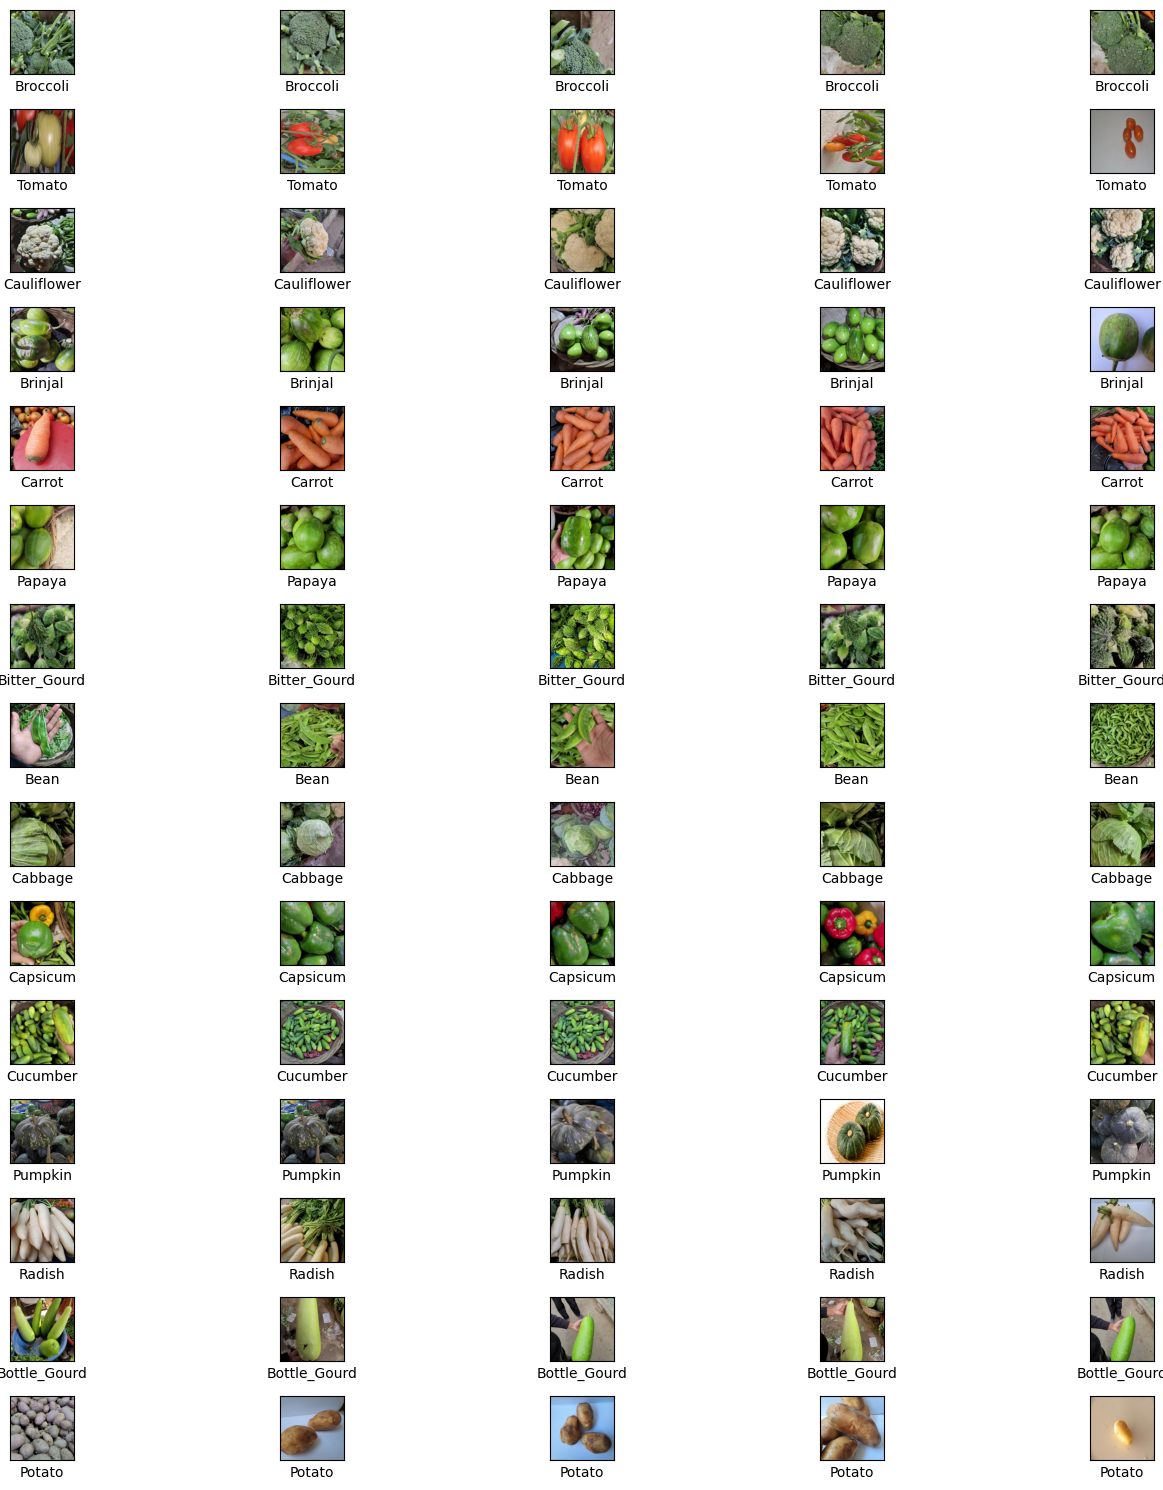

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

path = "/content/folder_dataset"
for i in os.listdir(path):
    lung_image[i] = os.listdir(os.path.join(path, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali.
path = "/content/folder_dataset"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        axs[i, j].imshow(imread(img_path))
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

#### Melihat distribusi data setiap label

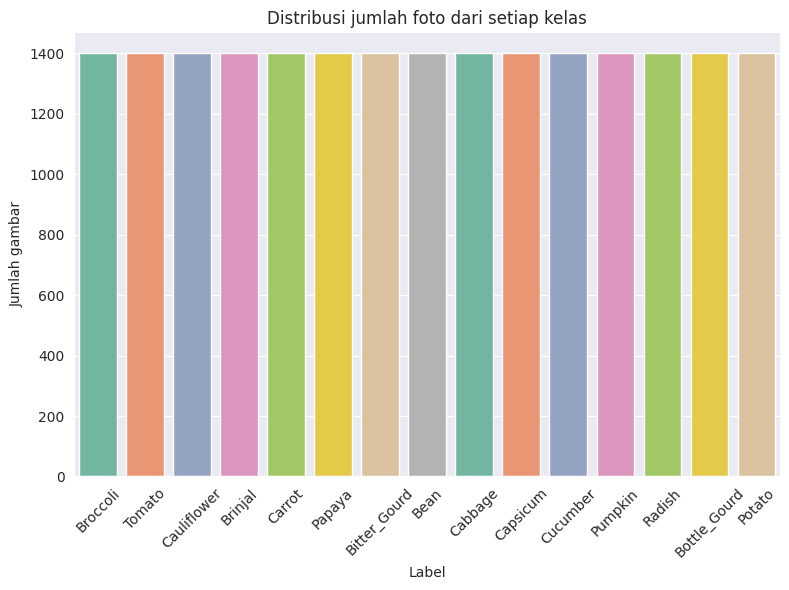

In [ ]:
# Define source path
lung_path = "/content/folder_dataset"

# Create a list that stores data for each filename, filepath, and label
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as a dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))  # Use os.path.basename() to get the last folder name
        file_name.append(name)

# Create a dataframe to store the paths, filenames, and labels
distribution_data = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot the distribution of images across the classes
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.set_style("darkgrid")
plot_data = sns.countplot(x='labels', data=distribution_data, palette="Set2")

# Labeling the plot
plt.title('Distribusi jumlah foto dari setiap kelas')
plt.xlabel('Label')
plt.ylabel('Jumlah gambar')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Path ke folder dataset
lung_path = "/content/folder_dataset"

# List untuk menyimpan informasi file
file_name = []
labels = []
full_path = []

# Looping untuk mengumpulkan data gambar
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))  # ambil nama folder sebagai label
        file_name.append(name)

# Buat DataFrame
distribution_data = pd.DataFrame({
    "path": full_path,
    "filename": file_name,
    "labels": labels
})

# Tampilkan tabel distribusi jumlah gambar per kelas
print("\nDistribusi jumlah gambar per kelas:")
print(distribution_data['labels'].value_counts().reset_index().rename(columns={'index': 'label', 'labels': 'count'}))


Distribusi jumlah gambar per kelas:
           count  count
0       Broccoli   1400
1         Tomato   1400
2    Cauliflower   1400
3        Brinjal   1400
4         Carrot   1400
5         Papaya   1400
6   Bitter_Gourd   1400
7           Bean   1400
8        Cabbage   1400
9       Capsicum   1400
10      Cucumber   1400
11       Pumpkin   1400
12        Radish   1400
13  Bottle_Gourd   1400
14        Potato   1400


#### Mengetahui resolusi dari setiap gambar

In [ ]:
# Fungsi ambil resolusi
def get_image_resolution(filepath):
    try:
        with Image.open(filepath) as img:
            return img.size  # (width, height)
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return (0, 0)

In [ ]:
# Path ke folder dataset
path = "/content/dataset"

# List data
data = []

# Loop semua file di folder
for filename in os.listdir(path):
    if os.path.isfile(os.path.join(path, filename)) and filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        filepath = os.path.join(path, filename)
        # Ambil label dari nama file, misal: 'carrot_001.jpg' → 'carrot'
        label = filename.split('_')[0]
        data.append({'filename': filename, 'filepath': filepath, 'label': label})

# Buat DataFrame
dataset_df = pd.DataFrame(data)

# Tambahkan resolusi
dataset_df['resolution'] = dataset_df['filepath'].apply(get_image_resolution)

# Pisahkan width & height
dataset_df[['width', 'height']] = pd.DataFrame(dataset_df['resolution'].tolist(), index=dataset_df.index)

# (Opsional) Tambahkan rasio
dataset_df['aspect_ratio'] = dataset_df['width'] / dataset_df['height']

# Tampilkan
dataset_df.head()

,filename,filepath,label,resolution,width,height,aspect_ratio
0,Bottle_Gourd_0190.jpg,/content/dataset/Bottle_Gourd_0190.jpg,Bottle,"(224, 224)",224,224,1.0
1,Cauliflower_0461.jpg,/content/dataset/Cauliflower_0461.jpg,Cauliflower,"(224, 224)",224,224,1.0
2,Cauliflower_0083.jpg,/content/dataset/Cauliflower_0083.jpg,Cauliflower,"(224, 224)",224,224,1.0
3,Bottle_Gourd_1035.jpg,/content/dataset/Bottle_Gourd_1035.jpg,Bottle,"(224, 224)",224,224,1.0
4,Tomato_0724.jpg,/content/dataset/Tomato_0724.jpg,Tomato,"(224, 224)",224,224,1.0


In [ ]:
dataset_df['resolution'].value_counts()

,count
resolution,
"(224, 224)",20991
"(224, 223)",1
"(224, 205)",1
"(224, 198)",1
"(224, 193)",1
"(224, 200)",1
"(224, 187)",1
"(224, 211)",1
"(224, 207)",1


#### Insight
* Gambar-gambar pada dataset asli memiliki resolusi yang tidak seragam (Tanpa preprocessing)
* Memiliki 8 kelas, yaitu: Baked Potato, Crispy Chicken, Donut, Fries, Hot Dog, Sandwich, Taco, Taquito
* Dataset yang digunakan berisi 12.048 gambar.

### Data Preprocessing

#### Split Dataset

In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= dataset_df['filepath']
y= dataset_df['label']

# Tahap 1: Split data ke train+val dan test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

# Tahap 2: Split lagi train+val menjadi train dan val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=300)  # 0.25 x 0.8 = 0.2

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_train = pd.DataFrame({'filepath':X_train,'label':y_train,'set':'train'})
df_test = pd.DataFrame({'filepath':X_test,'label':y_test,'set':'test'})
df_val = pd.DataFrame({'filepath':X_val,'label':y_val,'set':'val'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_train))
print('test size', len(df_test))
print('val size', len(df_val))

train size 12600
test size 4200
val size 4200


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_train, df_test, df_val], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'label']).size(), '\n')
print('===================================================== \n')

# Cek sample data
df_all.sample(5)


set    label      
test   Bean           262
       Bitter         265
       Bottle         277
       Brinjal        256
       Broccoli       275
       Cabbage        264
       Capsicum       290
       Carrot         318
       Cauliflower    277
       Cucumber       268
       Papaya         312
       Potato         290
       Pumpkin        283
       Radish         265
       Tomato         298
train  Bean           828
       Bitter         862
       Bottle         845
       Brinjal        869
       Broccoli       869
       Cabbage        847
       Capsicum       822
       Carrot         787
       Cauliflower    840
       Cucumber       849
       Papaya         813
       Potato         848
       Pumpkin        843
       Radish         846
       Tomato         832
val    Bean           310
       Bitter         273
       Bottle         278
       Brinjal        275
       Broccoli       256
       Cabbage        289
       Capsicum       288
       Carrot     

,filepath,label,set
19596,/content/dataset/Bottle_Gourd_0198.jpg,Bottle,val
13316,/content/dataset/Capsicum_0039.jpg,Capsicum,test
319,/content/dataset/Radish_0285.jpg,Radish,train
3138,/content/dataset/Capsicum_1221.jpg,Capsicum,train
9861,/content/dataset/Tomato_0749.jpg,Tomato,train


In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "/content/dataset/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "/content/Dataset-Final/"

In [ ]:
# Iterasi untuk menyalin file
for index, row in tq(df_all.iterrows(), total=len(df_all)):
    file_path = row['filepath']

    # Cek jika file_path tidak ada, coba fallback dengan path yang benar
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['label'], row['image'])  # Gak perlu diubah nama file

    # Cek dan buat direktori tujuan jika belum ada
    dest_dir = os.path.join(dataset_path, row['set'], row['label'])
    os.makedirs(dest_dir, exist_ok=True)  # Jangan khawatir jika folder sudah ada

    # Tentukan nama file tujuan
    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(dest_dir, destination_file_name)

    # Salin file ke tujuan jika belum ada
    if not os.path.exists(file_dest):
        try:
            shutil.copy2(file_path, file_dest)  # Salin file
        except Exception as e:
            print(f"Gagal menyalin {file_path} ke {file_dest}")
            print(f"Alasan: {e}")

  0%|          | 0/21000 [00:00<?, ?it/s]

## Modelling

In [ ]:
# Define training and test directories
train_dir = "Dataset-Final/train/"
test_dir = "Dataset-Final/test/"
val_dir = "Dataset-Final/val/"

In [ ]:
# Custom Callback berhenti saat akurasi sudah cukup bagus
class StopAtTargetAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
            print("\n\n Target akurasi tercapai. Menghentikan training...\n")
            self.model.stop_training = True

# Gabung semua callback jadi satu
def callback_model():
    return [
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1
        ),
        StopAtTargetAccuracy()
    ]

In [ ]:
def vegetable_model():
    TRAIN_DIR = 'Dataset-Final/train'
    VAL_DIR = 'Dataset-Final/val'
    TEST_DIR = 'Dataset-Final/test'

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    num_classes = train_generator.num_classes  # otomatis ambil jumlah kelas

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_generator,
        epochs=50,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=callback_model(),
        verbose=1
    )

    return model, history, test_generator

In [ ]:
model, history, test_generator = vegetable_model()

Found 12600 images belonging to 15 classes.
Found 4200 images belonging to 15 classes.
Found 4200 images belonging to 15 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 101s 232ms/step - accuracy: 0.1495 - loss: 2.4437 - val_accuracy: 0.3386 - val_loss: 1.7795 - learning_rate: 0.0010
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 127s 213ms/step - accuracy: 0.3286 - loss: 1.8614 - val_accuracy: 0.5529 - val_loss: 1.3393 - learning_rate: 0.0010
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 142s 213ms/step - accuracy: 0.4395 - loss: 1.5490 - val_accuracy: 0.6062 - val_loss: 1.1543 - learning_rate: 0.0010
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 141s 211ms/step - accuracy: 0.5330 - loss: 1.2988 - val_accuracy: 0.6450 - val_loss: 0.9366 - learning_rate: 0.0010
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 83s 211ms/step - accuracy: 0.6076 - loss: 1.1087 - val_accuracy: 0.7405 - val_loss: 0.7532 - learning_rate: 0.0010
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 91s 230ms/step - accuracy: 0.6623 - loss: 0.9631 - val_accuracy: 0.7943 - val_loss: 0.6272 - learning_rate: 0.0010
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 86s 219ms/step - accuracy:

## Evaluasi dan Visualisasi

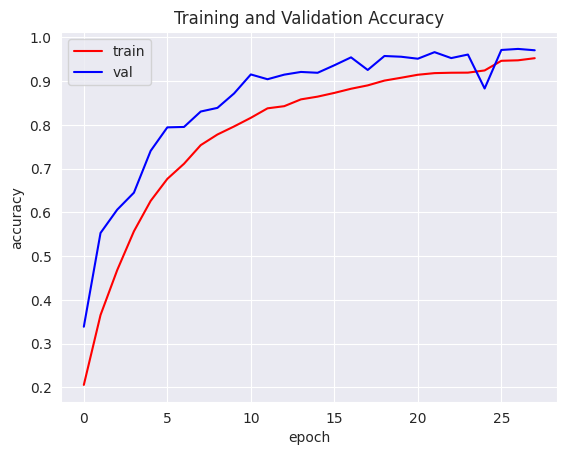

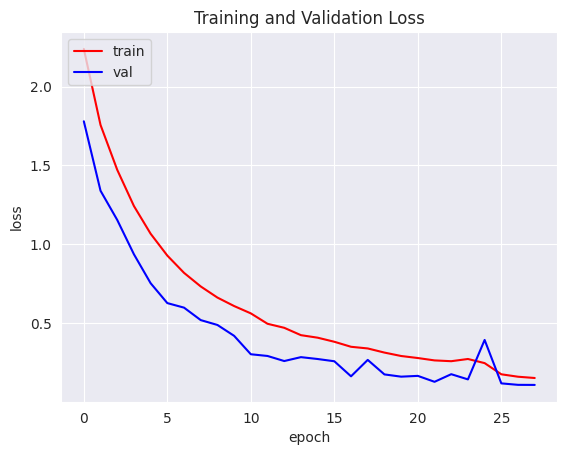

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9807 - loss: 0.0785
Akurasi pada data testing: 97.29%


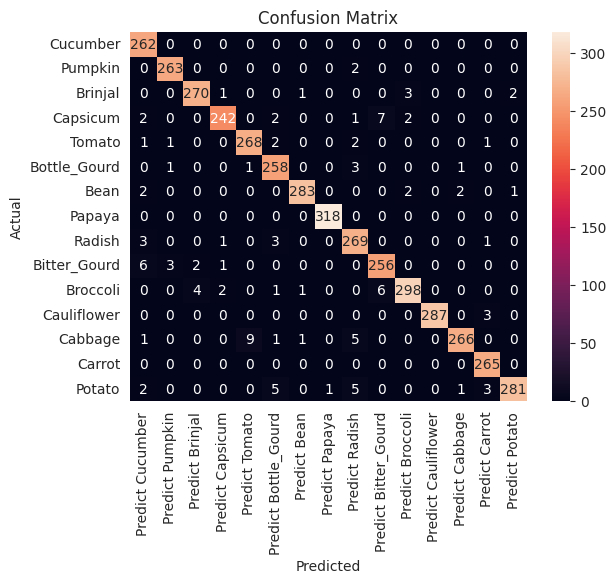


Classification Report:

              precision    recall  f1-score   support

    Cucumber     0.9391    1.0000    0.9686       262
     Pumpkin     0.9813    0.9925    0.9869       265
     Brinjal     0.9783    0.9747    0.9765       277
    Capsicum     0.9798    0.9453    0.9622       256
      Tomato     0.9640    0.9745    0.9693       275
Bottle_Gourd     0.9485    0.9773    0.9627       264
        Bean     0.9895    0.9759    0.9826       290
      Papaya     0.9969    1.0000    0.9984       318
      Radish     0.9373    0.9711    0.9539       277
Bitter_Gourd     0.9517    0.9552    0.9534       268
    Broccoli     0.9770    0.9551    0.9660       312
 Cauliflower     1.0000    0.9897    0.9948       290
     Cabbage     0.9852    0.9399    0.9620       283
      Carrot     0.9707    1.0000    0.9851       265
      Potato     0.9894    0.9430    0.9656       298

    accuracy                         0.9729      4200
   macro avg     0.9726    0.9729    0.9725      4200
w

In [ ]:
# Reset test generator untuk memastikan evaluasi dan prediksi dimulai dari awal
test_generator.reset()

# 1. Evaluasi model menggunakan evaluate()
loss, accuracy = model.evaluate(test_generator, verbose=1)
print(f"Akurasi pada data testing: {accuracy*100:.2f}%")

# 2. Prediksi data uji
preds = model.predict(test_generator, verbose=0)

# 3. Mengubah probabilitas menjadi label prediksi
pred_labels = np.argmax(preds, axis=1)

# 4. Confusion Matrix
cm = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, pred_labels, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]),
    index=["Cucumber", "Pumpkin", "Brinjal", "Capsicum", "Tomato", "Bottle_Gourd", "Bean", "Papaya", "Radish", "Bitter_Gourd", "Broccoli", "Cauliflower", "Cabbage", "Carrot", "Potato"],
    columns=["Predict Cucumber", "Predict Pumpkin", "Predict Brinjal", "Predict Capsicum", "Predict Tomato", "Predict Bottle_Gourd", "Predict Bean", "Predict Papaya", "Predict Radish", "Predict Bitter_Gourd", "Predict Broccoli", "Predict Cauliflower", "Predict Cabbage", "Predict Carrot", "Predict Potato"]
)

# 5. Visualisasi confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 6. Classification Report
print("\nClassification Report:\n")
print(classification_report(
    test_generator.classes,
    pred_labels,
    target_names=["Cucumber", "Pumpkin", "Brinjal", "Capsicum", "Tomato", "Bottle_Gourd", "Bean", "Papaya", "Radish", "Bitter_Gourd", "Broccoli", "Cauliflower", "Cabbage", "Carrot", "Potato"],
    digits=4
))

## Konversi Model

### Saved Model

In [ ]:
# Simpan model ke format SavedModel
model.export('saved_model')

shutil.make_archive('saved_model', 'zip', 'saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  140203080628368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140203080627408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140203080622800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140203080626640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140203080627024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140203080624336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140203080623568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140203080621264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140203080621648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140203080620880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140203080620688: T

'/content/saved_model.zip'

### Tensorflow lite

In [ ]:
# Load the TensorFlow SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

# Save the converted model to a file
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
class_labels = ["Cucumber", "Pumpkin", "Brinjal", "Capsicum","Tomato","Bottle_Gourd","Bean","Papaya", "Radish", "Bitter_Gourd", "Broccoli", "Cauliflower", "Cabbage", "Carrot", "Potato"]

with open('label.txt', 'w') as f:
    for label in class_labels:
        f.write(f"{label}\n")

## TFJS_model

In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/saved_model/ \
    /content/tfjs_model

2025-04-23 03:10:11.644470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745377811.665909   15222 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745377811.672375   15222 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-23 03:10:18.387710: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745377818.387939   15222 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
shutil.make_archive('tfjs_model', 'zip', 'tfjs_model')

'/content/tfjs_model.zip'

## Inference (Optional)

Saving sedang_1511309554pepaya.jpg to sedang_1511309554pepaya.jpg


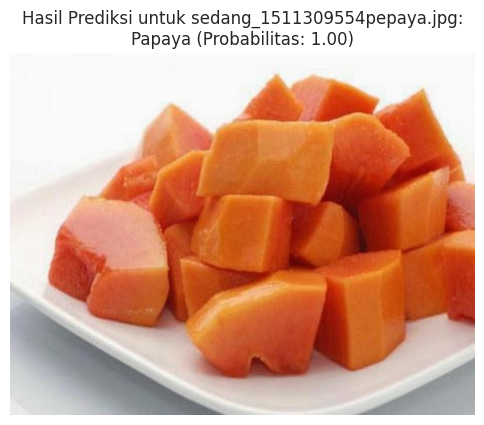

In [ ]:
# Import library
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io

# Upload gambar
uploaded_imgs = files.upload()

# Inisialisasi model TensorFlow Lite
interpreter = tf.lite.Interpreter(model_path='/content/model.tflite')
interpreter.allocate_tensors()

# Ambil detail input dan output model
input_info = interpreter.get_input_details()
output_info = interpreter.get_output_details()

# Fungsi untuk memproses gambar sebelum prediksi
def prepare_image(img, size):
    img = img.convert('RGB')  # Pastikan gambar dalam format RGB
    img = img.resize(size)
    img_array = np.array(img).astype('float32') / 255.0  # Normalisasi
    return np.expand_dims(img_array, axis=0)  # Tambah dimensi batch

# Baca label kelas dari file
with open('/content/label.txt', 'r') as label_file:
    labels = label_file.read().splitlines()

# Ukuran input yang diharapkan oleh model
input_size = (150, 150)  # Sesuaikan dengan arsitektur model

# Prediksi untuk setiap gambar yang diunggah
for name in uploaded_imgs.keys():
    img = Image.open(io.BytesIO(uploaded_imgs[name]))
    processed_img = prepare_image(img, input_size)

    # Masukkan data ke dalam model
    interpreter.set_tensor(input_info[0]['index'], processed_img)

    # Jalankan model
    interpreter.invoke()

    # Ambil hasil prediksi
    output_data = interpreter.get_tensor(output_info[0]['index'])
    predicted_index = np.argmax(output_data)
    predicted_label = labels[predicted_index]

    # Tampilkan gambar dan hasil prediksi
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Hasil Prediksi untuk {name}:\n{predicted_label} (Probabilitas: {output_data[0][predicted_index]:.2f})")
    plt.axis('off')
    plt.show()

Saving images (1).jpeg to images (1).jpeg


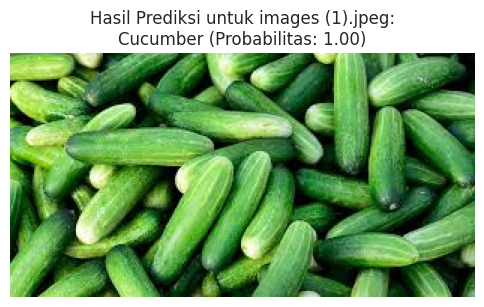

In [ ]:
# Import library
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io

# Upload gambar
uploaded_imgs = files.upload()

# Inisialisasi model TensorFlow Lite
interpreter = tf.lite.Interpreter(model_path='/content/model.tflite')
interpreter.allocate_tensors()

# Ambil detail input dan output model
input_info = interpreter.get_input_details()
output_info = interpreter.get_output_details()

# Fungsi untuk memproses gambar sebelum prediksi
def prepare_image(img, size):
    img = img.convert('RGB')  # Pastikan gambar dalam format RGB
    img = img.resize(size)
    img_array = np.array(img).astype('float32') / 255.0  # Normalisasi
    return np.expand_dims(img_array, axis=0)  # Tambah dimensi batch

# Baca label kelas dari file
with open('/content/label.txt', 'r') as label_file:
    labels = label_file.read().splitlines()

# Ukuran input yang diharapkan oleh model
input_size = (150, 150)  # Sesuaikan dengan arsitektur model

# Prediksi untuk setiap gambar yang diunggah
for name in uploaded_imgs.keys():
    img = Image.open(io.BytesIO(uploaded_imgs[name]))
    processed_img = prepare_image(img, input_size)

    # Masukkan data ke dalam model
    interpreter.set_tensor(input_info[0]['index'], processed_img)

    # Jalankan model
    interpreter.invoke()

    # Ambil hasil prediksi
    output_data = interpreter.get_tensor(output_info[0]['index'])
    predicted_index = np.argmax(output_data)
    predicted_label = labels[predicted_index]

    # Tampilkan gambar dan hasil prediksi
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Hasil Prediksi untuk {name}:\n{predicted_label} (Probabilitas: {output_data[0][predicted_index]:.2f})")
    plt.axis('off')
    plt.show()

## Requirements

In [ ]:
!pip freeze > Requirements.txt